In [4]:
### LIBRERÍAS

import os
import glob
import numpy as np
from tqdm import tqdm
from PIL import Image
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Paths

BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
IMG_TRAIN_DIR = os.path.join(BASE_DIR, 'data', 'MASATI', 'output', 'train', 'images')
IMG_TEST_DIR = os.path.join(BASE_DIR, 'data', 'MASATI', 'output', 'test', 'images')
IMG_VAL_DIR = os.path.join(BASE_DIR, 'data', 'MASATI', 'output', 'val', 'images')
LBL_TRAIN_DIR = os.path.join(BASE_DIR, 'data', 'MASATI', 'output', 'train', 'labels')
LBL_TEST_DIR = os.path.join(BASE_DIR, 'data', 'MASATI', 'output', 'test', 'labels')
LBL_VAL_DIR = os.path.join(BASE_DIR, 'data', 'MASATI', 'output', 'val', 'labels')

# Análisis Exploratorio de Datos

In [30]:
# 
print("Train images:", len(glob.glob(os.path.join(IMG_TRAIN_DIR, '*.png'))))
print("Validation images:", len(glob.glob(os.path.join(IMG_VAL_DIR, '*.png'))))
print("Test images:", len(glob.glob(os.path.join(IMG_TEST_DIR, '*.png'))))

Train images: 3617
Validation images: 452
Test images: 453


In [28]:
# las labels se encuentran dentro de archivos .txt, por lo que se debe leer cada archivo y extraer la información de las etiquetas
# el nombre del archivo de la imagen y el archivo de la etiqueta son iguales
# puede haber más de una etiqueta por imagen, por lo que se debe leer cada línea del archivo de etiquetas

def load_labels(label_dir):
    labels = []
    for label_file in tqdm(glob.glob(os.path.join(label_dir, '*.txt')), desc="Loading labels"):
        with open(label_file, 'r') as f:
            labels_img = [line.strip() for line in f if line.strip() != '']
            
        if labels_img:
            labels.append(labels_img)
    return labels

print("\nTRAINING")
labels_train = load_labels(LBL_TRAIN_DIR)
print("There are", len(labels_train), "images with boats")
print("The mean number of boats in those images is ", np.mean([len(l) for l in labels_train]))

print("\nVALIDATION")
labels_val = load_labels(LBL_VAL_DIR)
print("There are", len(labels_val), "images with boats")
print("The mean number of boats in those images is ", np.mean([len(l) for l in labels_val]))

print("\nTESTING")
labels_test = load_labels(LBL_TEST_DIR)
print("There are", len(labels_test), "images with boats")
print("The mean number of boats in those images is ", np.mean([len(l) for l in labels_test]))


TRAINING


Loading labels:   0%|          | 0/3617 [00:00<?, ?it/s]

Loading labels: 100%|██████████| 3617/3617 [00:00<00:00, 6904.93it/s]


There are 1888 images with boats
The mean number of boats in those images is  1.7309322033898304

VALIDATION


Loading labels: 100%|██████████| 452/452 [00:00<00:00, 6405.18it/s]


There are 237 images with boats
The mean number of boats in those images is  1.6160337552742616

TESTING


Loading labels: 100%|██████████| 453/453 [00:00<00:00, 7105.75it/s]

There are 243 images with boats
The mean number of boats in those images is  1.6584362139917694


La mitad de las imágenes no poseen barcos, pero las imágenes que sí tienen, pueden contener más de uno.

C:\Users\gonza\AppData\Local\Temp\ipykernel_6408\1436544970.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=num_barcos, palette='Set2')    # Una barra por cada valor distinto, con 20 colores distintos


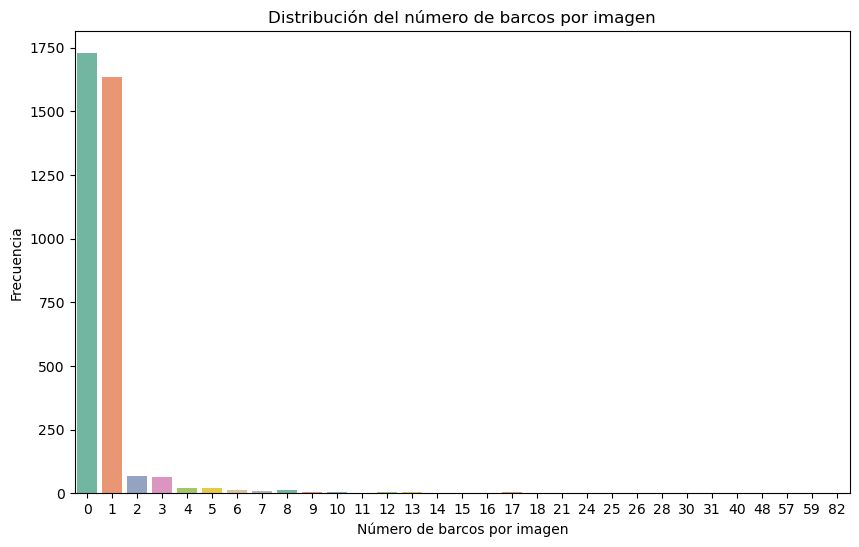

In [53]:

num_barcos = [len(l) for l in labels_train]
#añado las imagenes con 0 barcos
for i in range(len(labels_train), 3617):
    num_barcos.append(0)

# distribución del numero de barcos por imagen en train
plt.figure(figsize=(10, 6))
sns.countplot(x=num_barcos, palette='Set2')    # Una barra por cada valor distinto, con 20 colores distintos

plt.xlabel('Número de barcos por imagen')
plt.ylabel('Frecuencia')
plt.title('Distribución del número de barcos por imagen')
plt.show()


Existen imágenes con incluso 82 barcos, aunque vemos que la gran mayoría tienen uno o ninguno.

In [29]:
#leer clases de las etiquetas
def get_classes(labels):
    classes = set()
    for label in labels:
        for l in label:
            classes.add(l.split()[0])
    return list(classes)

classes_train = get_classes(labels_train)
classes_train


['0']

Solo hay una clase en el conjunto de datos, que corresponde a la detección de un barco.

Dimensiones de las imágenes en general: 512x512 píxeles.

(momstrar grafica con dimensiones pa comprobar)

# MACHINE LEARNING (CLASIFICACIÓN)

In [3]:
# Función para saber si hay barco
def has_boat(label_path):
    return os.path.exists(label_path) and os.path.getsize(label_path) > 0

# Extraer características HOG usando Pillow
def extract_features(image_path):
    image = Image.open(image_path).convert("L")  # Convertir a escala de grises
    image = image.resize((128, 128))  # Redimensionar
    image_np = np.array(image)

    features, _ = hog(image_np,
                      pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2),
                      visualize=True)
    return features

In [4]:
# Cargar imágenes de entrenamiento
X_train, y_train = [], []
train_image_paths = glob.glob(os.path.join(IMG_TRAIN_DIR, '*.png'))

for img_path in tqdm(train_image_paths, desc="Extrayendo características de entrenamiento"):
    filename = os.path.splitext(os.path.basename(img_path))[0] + '.txt'
    label_path = os.path.join(LBL_TRAIN_DIR, filename)  # Ruta de etiquetas de entrenamiento

    label = int(has_boat(label_path))
    features = extract_features(img_path)

    X_train.append(features)
    y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Cargar imágenes de prueba
X_test, y_test = [], []
test_image_paths = glob.glob(os.path.join(IMG_TEST_DIR, '*.png'))

for img_path in tqdm(test_image_paths, desc="Extrayendo características de test"):
    filename = os.path.splitext(os.path.basename(img_path))[0] + '.txt'
    label_path = os.path.join(LBL_TEST_DIR, filename)  # Ruta de etiquetas de prueba

    label = int(has_boat(label_path))  # Si tienes etiquetas para test (puedes omitir esto si no las tienes)
    features = extract_features(img_path)

    X_test.append(features)
    y_test.append(label)

X_test = np.array(X_test)
y_test = np.array(y_test)

Extrayendo características de test: 100%|████████████████████████████████████████████| 453/453 [00:48<00:00,  9.31it/s]


In [5]:
# Modelo
model = SVC(kernel='linear', probability=True)
model.fit(X_train, y_train)

# Evaluación en conjunto de prueba
y_pred = model.predict(X_test)

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=["No barco", "Barco"]))


Reporte de clasificación:
              precision    recall  f1-score   support

    No barco       0.58      0.57      0.57       210
       Barco       0.63      0.64      0.64       243

    accuracy                           0.61       453
   macro avg       0.60      0.60      0.60       453
weighted avg       0.61      0.61      0.61       453



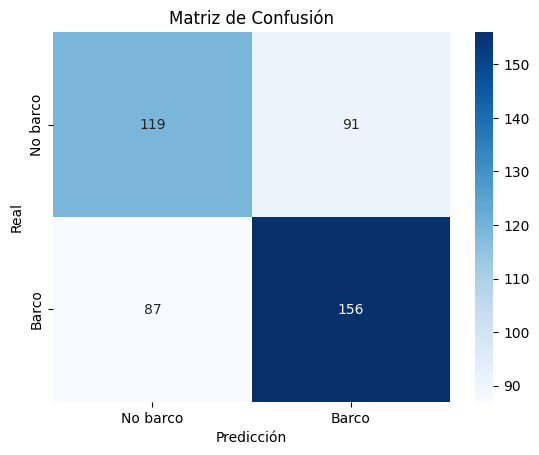

In [6]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No barco", "Barco"], yticklabels=["No barco", "Barco"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

# DEEP LEARNING: YOLO

You Only Look Once (YOLO) es un algoritmo de detección de objetos en imágenes. A diferencia de otros métodos que analizan la imagen en varias etapas, YOLO trata la detección como un problema de regresión único, lo que lo hace más rápido y eficiente.

Existen múltiples versiones de YOLO, cada una mejorando la precisión y velocidad del modelo. Se usará YOLO v8.

In [1]:
from ultralytics import YOLO
import torch
import cv2

In [2]:
# gpu o cpu
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


Carga del modelo YOLO v8 preentrenado. Este modelo ha sido entrenado en el conjunto de datos COCO, que contiene 80 clases de objetos. Se realizará un ajuste fino (fine-tuning) del modelo para adaptarlo a nuestro conjunto de datos específico, que solo tiene una clase: barco.

In [ ]:
model = YOLO('yolov8n.pt') # modelo mas pequeño

100%|██████████| 6.25M/6.25M [00:00<00:00, 37.9MB/s]


## Entrenamiento

In [7]:
YAML_DATA = os.path.join(BASE_DIR, 'data', 'data.yaml')

# Ajuste los hiperparámetros y entrenamiento del modelo
#    - data: data.yaml
#    - epochs: nº de épocas 
#    - imgsz: tamaño de lado de las imágenes 
#    - batch: tamaño de lote 
#    - device: GPU o CPU
model.train(
    data=YAML_DATA,
    epochs=50,
    imgsz=512,
    batch=32,
    device=device,
    name='first-boat-detection-nano',
)

New https://pypi.org/project/ultralytics/8.3.127 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.126  Python-3.12.10 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=c:\Users\gonza\Desktop\ImagenADNE\DeepLearning-Images\data\data.yaml, degrees=0.0, deterministic=True, device=cuda:0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scal

100%|██████████| 755k/755k [00:00<00:00, 8.10MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

 19                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
 20             [-1, 9]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 21                  -1  1    493056  ultralytics.nn.modules.block.C2f             [384, 256, 1]                 
 22        [15, 18, 21]  1    751507  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
Model summary: 129 layers, 3,011,043 parameters, 3,011,027 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 21.2MB/s]


AMP: checks passed 
train: Fast image access  (ping: 0.40.0 ms, read: 18.413.5 MB/s, size: 282.7 KB)


train: Scanning C:\Users\gonza\Desktop\ImagenADNE\DeepLearning-Images\data\MASATI\output\train\labels... 3617 images, 1729 backgrounds, 0 corrupt: 100%|██████████| 3617/3617 [00:08<00:00, 419.85it/s]


train: New cache created: C:\Users\gonza\Desktop\ImagenADNE\DeepLearning-Images\data\MASATI\output\train\labels.cache
val: Fast image access  (ping: 0.50.3 ms, read: 16.610.1 MB/s, size: 333.8 KB)


val: Scanning C:\Users\gonza\Desktop\ImagenADNE\DeepLearning-Images\data\MASATI\output\val\labels... 452 images, 215 backgrounds, 0 corrupt: 100%|██████████| 452/452 [00:01<00:00, 384.83it/s]

val: New cache created: C:\Users\gonza\Desktop\ImagenADNE\DeepLearning-Images\data\MASATI\output\val\labels.cache


Plotting labels to runs\detect\first-boat-detection-nano\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 8 dataloader workers
Logging results to runs\detect\first-boat-detection-nano
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.57G      2.177       5.15      1.053          1        512: 100%|██████████| 227/227 [00:39<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.63it/s]

                   all        452        383      0.685      0.514      0.539      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50       1.6G      2.202      2.571      1.095          0        512: 100%|██████████| 227/227 [00:33<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.29it/s]

                   all        452        383      0.661      0.538      0.577      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50       1.6G      2.218      1.796      1.108          0        512: 100%|██████████| 227/227 [00:32<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.34it/s]

                   all        452        383      0.664      0.579      0.584      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      1.74G      2.157      1.596       1.09          1        512: 100%|██████████| 227/227 [00:31<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.55it/s]

                   all        452        383      0.734      0.633      0.677      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      1.76G      2.121      1.489      1.073          0        512: 100%|██████████| 227/227 [00:32<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.31it/s]

                   all        452        383       0.73      0.634      0.673       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.77G      2.091      1.419      1.082          0        512: 100%|██████████| 227/227 [00:31<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.50it/s]

                   all        452        383      0.604      0.572      0.561      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      1.78G      2.086      1.456      1.076          1        512: 100%|██████████| 227/227 [00:32<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.48it/s]

                   all        452        383      0.651      0.595      0.625      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.92G      2.053      1.419      1.068          0        512: 100%|██████████| 227/227 [00:32<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.58it/s]

                   all        452        383      0.758      0.597      0.661      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.93G       2.01      1.347      1.051          0        512: 100%|██████████| 227/227 [00:32<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.57it/s]

                   all        452        383       0.72      0.587      0.652      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.95G      2.032      1.357       1.06          1        512: 100%|██████████| 227/227 [00:31<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.84it/s]

                   all        452        383      0.678      0.533       0.59      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      1.96G       1.98      1.275      1.047          1        512: 100%|██████████| 227/227 [00:32<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.63it/s]

                   all        452        383       0.79      0.585      0.688      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.98G      2.013      1.273      1.053          1        512: 100%|██████████| 227/227 [00:32<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.17it/s]

                   all        452        383      0.779      0.663      0.717       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         2G      1.955      1.222      1.018          0        512: 100%|██████████| 227/227 [00:30<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  6.14it/s]

                   all        452        383      0.719      0.658      0.695      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.02G      1.948      1.224      1.047          1        512: 100%|██████████| 227/227 [00:29<00:00,  7.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  6.30it/s]

                   all        452        383      0.815      0.608      0.702      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.03G      1.921      1.196      1.018          1        512: 100%|██████████| 227/227 [00:29<00:00,  7.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.92it/s]

                   all        452        383      0.777      0.679      0.749      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.05G      1.928      1.204       1.02          0        512: 100%|██████████| 227/227 [00:33<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.72it/s]

                   all        452        383      0.766       0.71      0.752      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.07G      1.909      1.196      1.006          0        512: 100%|██████████| 227/227 [00:32<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.81it/s]

                   all        452        383      0.831      0.658      0.744      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.09G      1.891      1.172      1.016          0        512: 100%|██████████| 227/227 [00:31<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.42it/s]

                   all        452        383      0.775      0.621       0.69      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.09G      1.893       1.18       1.02          1        512: 100%|██████████| 227/227 [00:32<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.16it/s]

                   all        452        383      0.615      0.616      0.622      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.12G      1.916      1.127       1.02          0        512: 100%|██████████| 227/227 [00:32<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.42it/s]

                   all        452        383      0.846      0.621      0.748      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.14G      1.863      1.113     0.9999          0        512: 100%|██████████| 227/227 [00:32<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.62it/s]

                   all        452        383      0.783        0.7      0.749      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.15G      1.849      1.113     0.9865          1        512: 100%|██████████| 227/227 [00:31<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.55it/s]

                   all        452        383      0.765      0.687      0.732      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.16G      1.856      1.098      1.001          3        512: 100%|██████████| 227/227 [00:32<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.59it/s]

                   all        452        383      0.764      0.627      0.719       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.19G      1.881       1.08     0.9939          2        512: 100%|██████████| 227/227 [00:32<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.69it/s]

                   all        452        383       0.85      0.682       0.78      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.21G      1.826      1.058     0.9991          0        512: 100%|██████████| 227/227 [00:31<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.64it/s]

                   all        452        383      0.853      0.712      0.777      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.22G      1.825      1.046     0.9952          1        512: 100%|██████████| 227/227 [00:32<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.71it/s]

                   all        452        383      0.855      0.681      0.753      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.23G      1.816      1.061      0.995          0        512: 100%|██████████| 227/227 [00:32<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.51it/s]

                   all        452        383       0.81        0.7      0.753      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.26G      1.823      1.032     0.9975          0        512: 100%|██████████| 227/227 [00:32<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.60it/s]

                   all        452        383      0.842      0.705      0.786      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.27G      1.756      1.044     0.9828          0        512: 100%|██████████| 227/227 [00:32<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.21it/s]

                   all        452        383      0.813      0.668      0.756      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.29G      1.833       1.02     0.9963          1        512: 100%|██████████| 227/227 [00:32<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.69it/s]

                   all        452        383      0.813      0.681      0.771       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50       2.3G      1.785      1.014     0.9888          0        512: 100%|██████████| 227/227 [00:33<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.75it/s]

                   all        452        383      0.885      0.661      0.783      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.33G      1.813       1.02     0.9852          0        512: 100%|██████████| 227/227 [00:33<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.35it/s]

                   all        452        383      0.882      0.686      0.786      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.34G      1.806      1.012     0.9932         10        512: 100%|██████████| 227/227 [00:33<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.16it/s]

                   all        452        383       0.83      0.697      0.787      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.36G      1.772     0.9743     0.9895          0        512: 100%|██████████| 227/227 [00:34<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.38it/s]

                   all        452        383       0.82       0.69      0.764      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.57G      1.763     0.9789     0.9746          0        512: 100%|██████████| 227/227 [00:33<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.37it/s]

                   all        452        383      0.812      0.699      0.771      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50       2.6G      1.751     0.9638     0.9831          1        512: 100%|██████████| 227/227 [00:34<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.97it/s]

                   all        452        383      0.826      0.743      0.805      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.62G      1.749     0.9596     0.9732          0        512: 100%|██████████| 227/227 [00:33<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.53it/s]

                   all        452        383      0.862      0.717      0.806      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.63G      1.744      0.954     0.9787          0        512: 100%|██████████| 227/227 [00:32<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.68it/s]

                   all        452        383      0.835      0.736      0.814      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.64G      1.734     0.9252     0.9715          0        512: 100%|██████████| 227/227 [00:32<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.57it/s]

                   all        452        383      0.915      0.675      0.809      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.67G      1.742     0.9359     0.9713          0        512: 100%|██████████| 227/227 [00:32<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.16it/s]

                   all        452        383       0.84      0.724      0.813      0.354


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.69G      1.703     0.9363     0.9823          0        512: 100%|██████████| 227/227 [00:32<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.54it/s]

                   all        452        383      0.879      0.697        0.8      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50       2.7G      1.704     0.9214     0.9824          1        512: 100%|██████████| 227/227 [00:33<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.61it/s]

                   all        452        383      0.892      0.711      0.818      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.71G      1.681     0.8846      0.985          0        512: 100%|██████████| 227/227 [00:33<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.14it/s]

                   all        452        383      0.852      0.749      0.815      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.74G       1.68     0.8963     0.9782          1        512: 100%|██████████| 227/227 [00:32<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.38it/s]

                   all        452        383      0.855      0.744      0.815      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.75G      1.668     0.8663     0.9895          1        512: 100%|██████████| 227/227 [00:32<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.87it/s]

                   all        452        383      0.882       0.76      0.838      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.77G       1.65     0.8557     0.9794          1        512: 100%|██████████| 227/227 [00:31<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.62it/s]

                   all        452        383      0.856      0.734      0.819      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.78G      1.646     0.8693     0.9876          1        512: 100%|██████████| 227/227 [00:31<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.80it/s]

                   all        452        383      0.871      0.747      0.818      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50       2.8G      1.619     0.8483     0.9653          4        512: 100%|██████████| 227/227 [00:31<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.70it/s]

                   all        452        383      0.845      0.755      0.803      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.82G      1.596     0.8385      0.949          0        512: 100%|██████████| 227/227 [00:31<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.83it/s]

                   all        452        383      0.821      0.766      0.808      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.84G      1.604     0.8178     0.9739          0        512: 100%|██████████| 227/227 [00:32<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.69it/s]

                   all        452        383      0.838       0.77      0.811      0.359



50 epochs completed in 0.509 hours.
Optimizer stripped from runs\detect\first-boat-detection-nano\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\first-boat-detection-nano\weights\best.pt, 6.2MB

Validating runs\detect\first-boat-detection-nano\weights\best.pt...
Ultralytics 8.3.126  Python-3.12.10 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.87it/s]


                   all        452        383      0.893       0.76      0.838      0.365
Speed: 0.2ms preprocess, 1.5ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs\detect\first-boat-detection-nano


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000234F1E4D4C0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

Las gráficas del entrenamiento se encuentran en el directorio runs

Matriz de confusión:

![Matriz de confusión](runs/detect/first-boat-detection-nano/confusion_matrix.png)

Métricas de entrenamiento:
![Métricas de entrenamiento](runs/detect/first-boat-detection-nano/results.png)

# Evaluación del modelo
Vamos a ver como se comporta con los datos de test.

In [9]:
path_modelo = os.path.join(BASE_DIR, 'code/runs/detect/first-boat-detection-nano/weights/best.pt')

In [10]:
# Evaluación del modelo con imagenes de test
model = YOLO(path_modelo)

In [12]:
#probar con una imagen de test y mostrar imagen
img_path = os.path.join(IMG_TEST_DIR, 'x0099.png')
results = model.predict(img_path, conf=0.5, iou=0.5, device=device)

# Obtener la imagen con los bounding boxes ya dibujados
#    La función plot() devuelve un ndarray BGR con las detecciones
annotated_img = results[0].plot()

# Mostrar imagen con OpenCV
window_name = "Detecciones de barcos"
cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
cv2.imshow(window_name, annotated_img)
 # espera a que pulses una tecla cualquiera o que cierres la ventana manualmente
while True:
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q') or cv2.getWindowProperty(window_name, cv2.WND_PROP_VISIBLE) < 1:
        break
# Cierra la ventana y libera los recursos
cv2.destroyAllWindows()


image 1/1 c:\Users\gonza\Desktop\ImagenADNE\DeepLearning-Images\data\MASATI\output\test\images\x0099.png: 512x512 1 boat, 22.8ms
Speed: 2.5ms preprocess, 22.8ms inference, 3.1ms postprocess per image at shape (1, 3, 512, 512)


## Mejora del entrenamiento
haciendo image augmentation y otras tecnicas de mejora de la red que aun no he probado y tengo que investigar.


In [ ]:

model.train(
    task='detect',
    mode='train',
    model='yolov8n.pt',
    data=r'c:\Users\gonza\Desktop\ImagenADNE\DeepLearning-Images\data\data.yaml',
    epochs=50,                # más épocas para converger mejor
    batch=16,
    imgsz=512,
    device=device,
    single_cls=True,           # solo una clase (barco)
    patience=30,               # early-stop tras 30 epochs sin mejora
    save=True,
    save_period=1,             # guarda pesos cada epoch
    optimizer='SGD',           # SGD suele dar mejor generalización en Nano
    lr0=0.005,                  # lr inicial algo más bajo
    lrf=0.1,                    # lr final = 0.1 * lr0
    momentum=0.9,
    weight_decay=0.0005,
    warmup_epochs=3.0,
    warmup_momentum=0.8,
    warmup_bias_lr=0.1,
    cos_lr=True,               # Cosine LR schedule
    amp=True,                  # Mixed Precision
    half=True,                 # FP16
    augment=True,
    mosaic=1.0,                # siempre mosaic
    mixup=0.2,                 # 20% mixup
    copy_paste=0.2,            # 20% copy-paste
    auto_augment='randaugment',
    multi_scale=True,          # escala variable
    name='boat-nano-optimized'
)